<a href="https://colab.research.google.com/github/Tasneem1028/CV-DL/blob/main/Skin_Lesion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#step 1: load the dataset

In [ ]:
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import top_k_categorical_accuracy
from sklearn.model_selection import train_test_split
from keras.models import load_model



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir="/content/drive/MyDrive/all images"
dest_dir="/content/reorganised"

In [ ]:
#read metadata
skin_df=pd.read_csv("/content/drive/MyDrive/HAM10000_metadata")
print(skin_df.head())


     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset  
0  vidir_modern  
1  vidir_modern  
2  vidir_modern  
3  vidir_modern  
4  vidir_modern  


In [ ]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

skin_df['label'] = le.transform(skin_df["dx"])
print(skin_df.sample(10))


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization        dataset  label  
1617             face   vidir_modern      4  
8128  lower extremity    vienna_dias      5  
2168             back      rosendahl      4  
1090            trunk  vidir_molemax      2  
775

<ipython-input-8-9c594ee24d5f>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


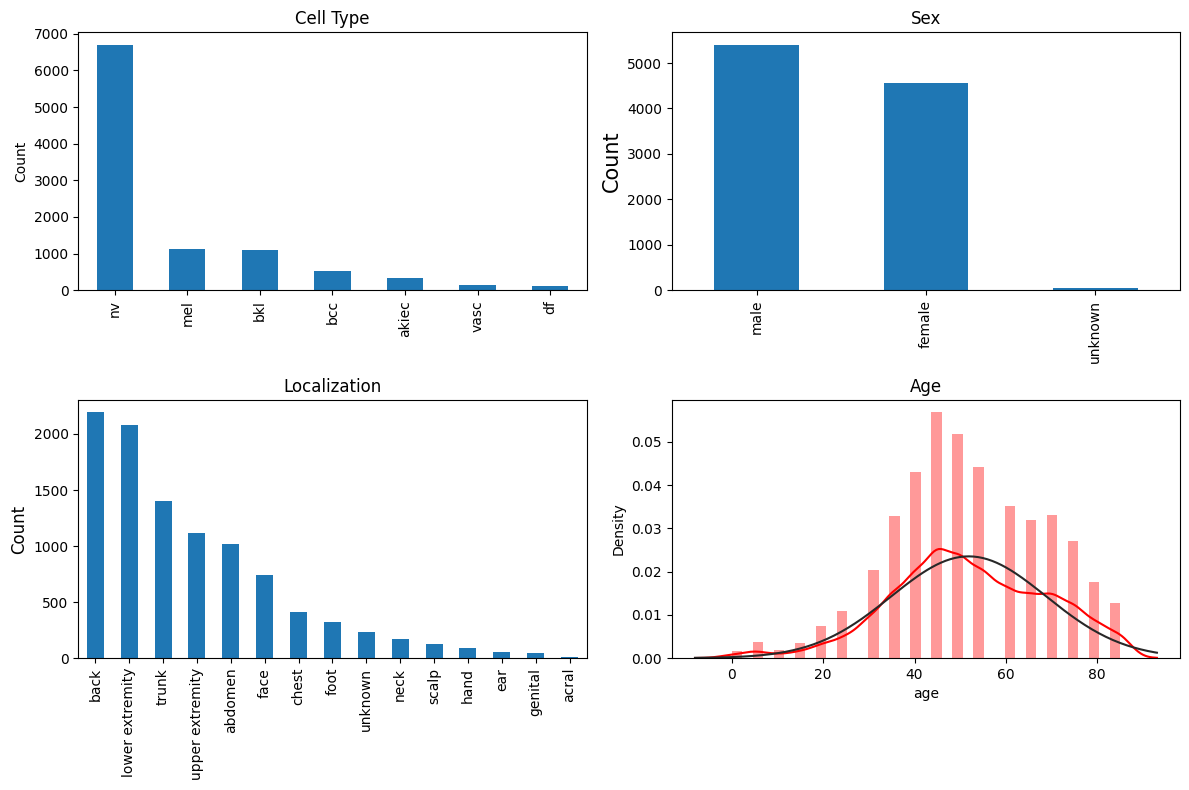

In [ ]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [ ]:
# Distribution of data into various classes
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [ ]:
#Balance data.
#Separate each classes, resample, and combine back into single dataframe
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced,
                              df_2_balanced, df_3_balanced,
                              df_4_balanced, df_5_balanced, df_6_balanced])




In [ ]:
#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [ ]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
x='/content/drive/MyDrive/all images/ISIC_0024306.jpg'
image_path = {os.path.basename(x): x for x in glob(os.path.join('/content/drive/MyDrive/all images/', '*.jpg'))}
#x='/content/drive/MyDrive/all images/ISIC_0024306.jpg'
file = os.path.splitext(str(os.path.basename(x)).split('.')[0])
file_name=file[0]

print(file_name)

In [ ]:
#Define the path and add as a new column
skin_df['image_id']=skin_df['image_id']+'.jpg'
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)


In [ ]:
print(image_path)
print(skin_df_balanced.sample(3))
print(skin_df['label'])
print(skin_df['dx'])

{'ISIC_0033294.jpg': '/content/drive/MyDrive/all images/ISIC_0033294.jpg', 'ISIC_0033318.jpg': '/content/drive/MyDrive/all images/ISIC_0033318.jpg', 'ISIC_0033344.jpg': '/content/drive/MyDrive/all images/ISIC_0033344.jpg', 'ISIC_0033323.jpg': '/content/drive/MyDrive/all images/ISIC_0033323.jpg', 'ISIC_0033335.jpg': '/content/drive/MyDrive/all images/ISIC_0033335.jpg', 'ISIC_0033326.jpg': '/content/drive/MyDrive/all images/ISIC_0033326.jpg', 'ISIC_0033338.jpg': '/content/drive/MyDrive/all images/ISIC_0033338.jpg', 'ISIC_0033341.jpg': '/content/drive/MyDrive/all images/ISIC_0033341.jpg', 'ISIC_0033340.jpg': '/content/drive/MyDrive/all images/ISIC_0033340.jpg', 'ISIC_0033342.jpg': '/content/drive/MyDrive/all images/ISIC_0033342.jpg', 'ISIC_0033331.jpg': '/content/drive/MyDrive/all images/ISIC_0033331.jpg', 'ISIC_0033327.jpg': '/content/drive/MyDrive/all images/ISIC_0033327.jpg', 'ISIC_0033325.jpg': '/content/drive/MyDrive/all images/ISIC_0033325.jpg', 'ISIC_0033336.jpg': '/content/drive/M

In [ ]:
#SKIN_DF_BALANCED HAS PATH COLOUMN AND SKIN_DF HAS IMAGE ID WITH .JPG

In [ ]:
#Use the path to read images.
SIZE=32
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [ ]:
print(skin_df_balanced.sample(3))

        lesion_id      image_id     dx dx_type   age   sex localization  \
9837  HAM_0003262  ISIC_0026212  akiec   histo  45.0  male         face   
94    HAM_0004852  ISIC_0030565    bkl   histo  65.0  male         face   
9928  HAM_0006560  ISIC_0028063  akiec   histo  50.0  male         face   

           dataset  label                                               path  \
9837     rosendahl      0  /content/drive/MyDrive/all images/ISIC_0026212...   
94    vidir_modern      2  /content/drive/MyDrive/all images/ISIC_0030565...   
9928     rosendahl      0  /content/drive/MyDrive/all images/ISIC_0028063...   

                                                  image  
9837  [[[190, 128, 142], [194, 129, 147], [200, 141,...  
94    [[[165, 124, 138], [168, 133, 151], [167, 127,...  
9928  [[[218, 127, 138], [220, 125, 138], [221, 130,...  


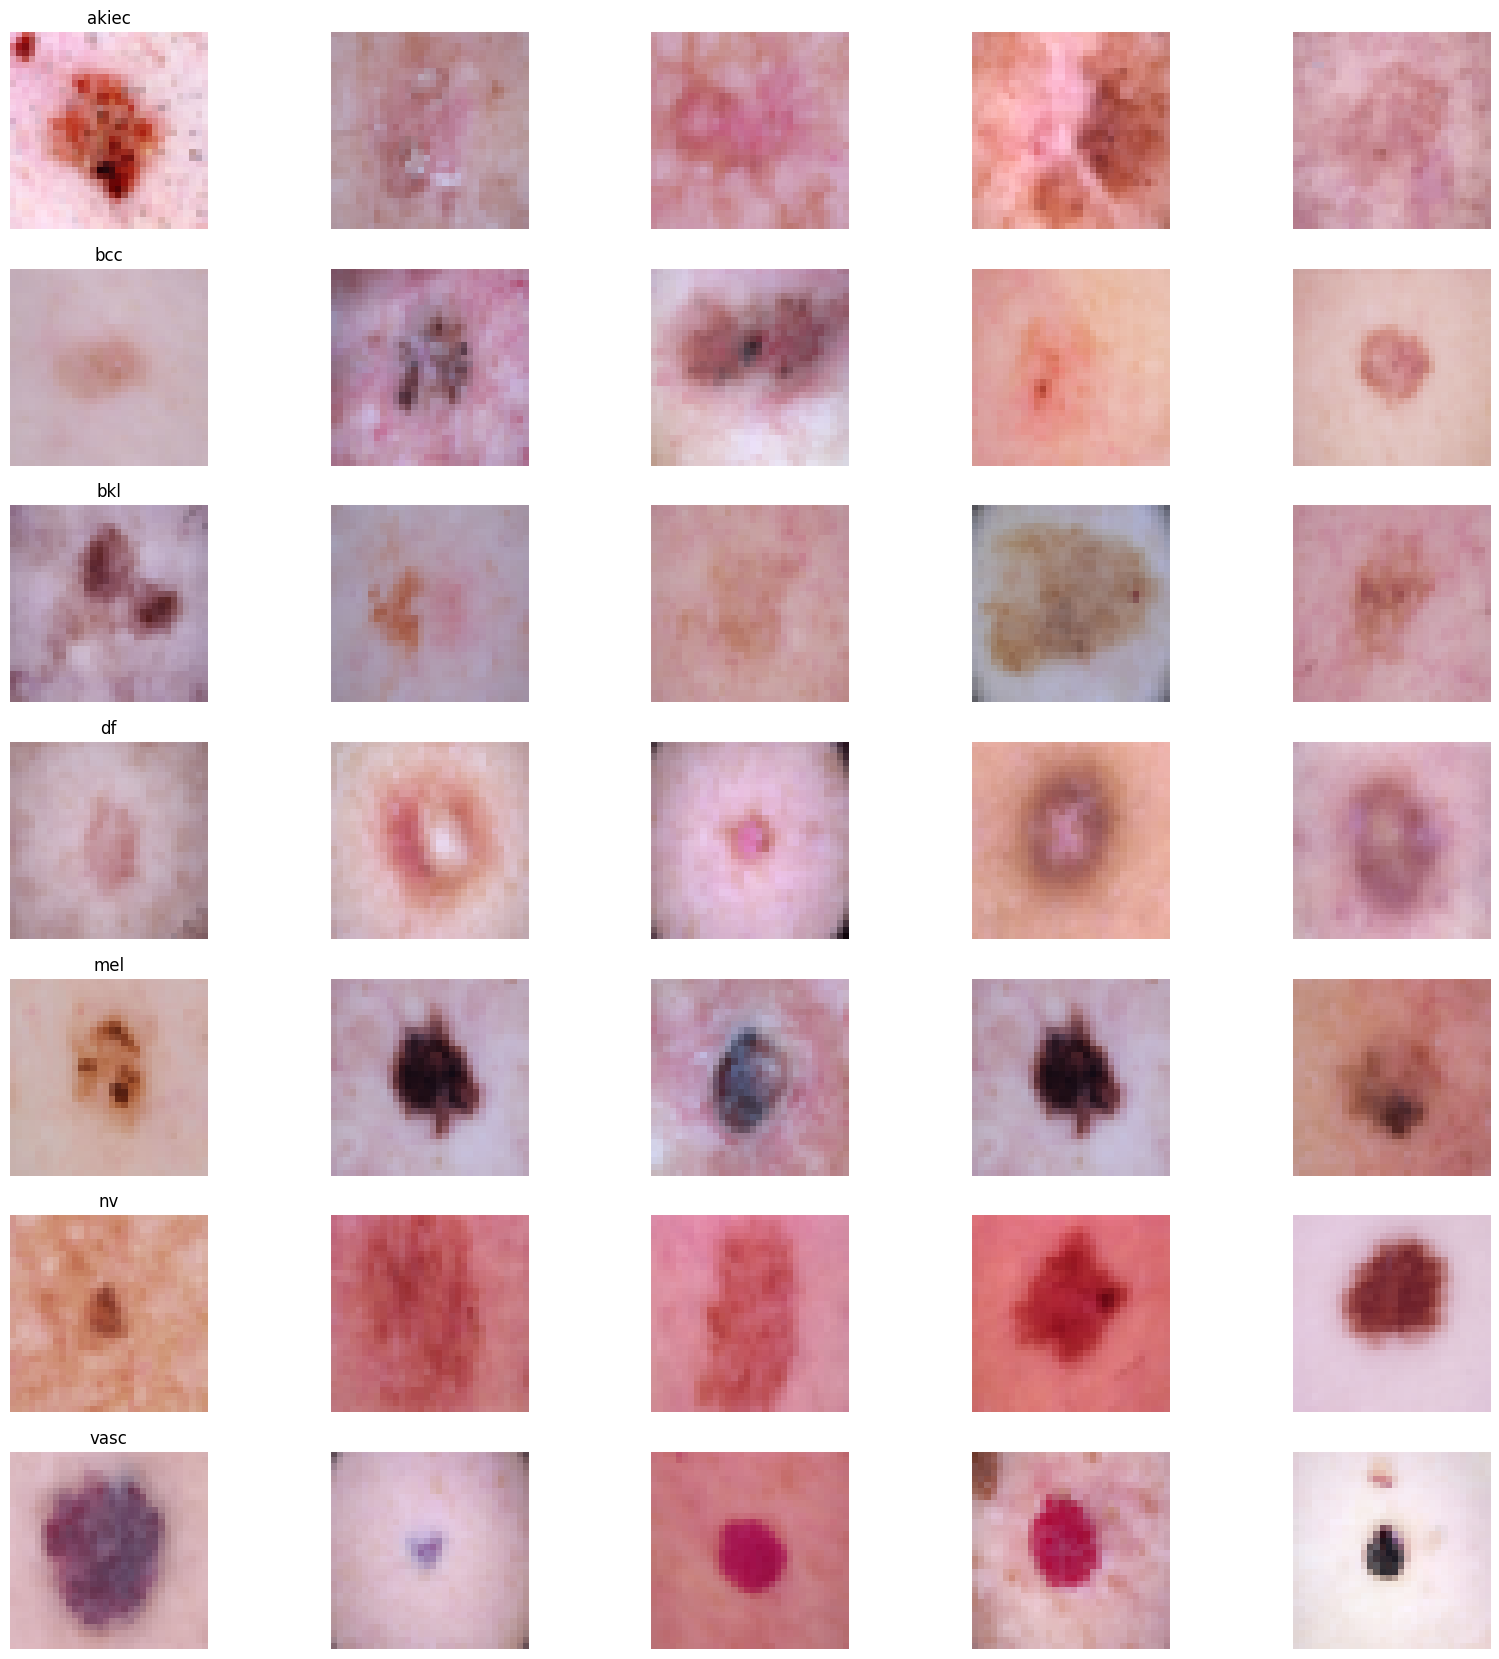

In [ ]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [ ]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)



In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
#AUGMNENTATION

In [ ]:
X = X / 255.  # Scale values to 0-1. You can also use standardscaler or other scaling methods.
Y = skin_df_balanced['label']  # Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7)  # Convert to categorical as this is a multiclass classification problem


In [ ]:
# Define the MobileNet-based model
image_size = 32
num_classes = 7

base_model = MobileNet(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
x = base_model.layers[-1].output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers except the last 23 layers for training
for layer in model.layers[:-23]:
    layer.trainable = False

# Custom accuracy metrics
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

# Compile the model
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['categorical_accuracy', top_2_accuracy, top_3_accuracy])

# Class weights
class_weights = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.7,
    5: 1.0,
    6: 1.0,
}
#{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
'''Melanocytic nevi (nv)
Benign Keratosis (bkl)
Dermatofibroma (df)
Actinic Keratosis (akiec)
vasculaer lesion(vas)
Melanoma (mel)
Basal Cell Carcinoma (bcc)
'''
# Checkpoint and learning rate reduction callbacks
filepath = "/content/drive/MyDrive/models.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.55, patience=2, verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]
# Train the model
batch_size = 32
epochs = 37

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) // batch_size,
    validation_data=(x_test, y_test),
    validation_steps=len(x_test) // batch_size,
    class_weight=class_weights,
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1
)

# Evaluate the model using the validation set
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = model.evaluate(x_test, y_test)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

Epoch 1/37
82/82 [==============================] - ETA: 0s - loss: 3.1207 - categorical_accuracy: 0.3413 - top_2_accuracy: 0.5438 - top_3_accuracy: 0.6988
Epoch 1: val_categorical_accuracy improved from -inf to 0.23543, saving model to /content/drive/MyDrive/models.h5
82/82 [==============================] - 26s 282ms/step - loss: 3.1207 - categorical_accuracy: 0.3413 - top_2_accuracy: 0.5438 - top_3_accuracy: 0.6988 - val_loss: 2.8666 - val_categorical_accuracy: 0.2354 - val_top_2_accuracy: 0.4103 - val_top_3_accuracy: 0.5703 - lr: 0.0010
Epoch 2/37
82/82 [==============================] - ETA: 0s - loss: 2.3004 - categorical_accuracy: 0.4069 - top_2_accuracy: 0.6278 - top_3_accuracy: 0.7802
Epoch 2: val_categorical_accuracy improved from 0.23543 to 0.34629, saving model to /content/drive/MyDrive/models.h5
82/82 [==============================] - 22s 268ms/step - loss: 2.3004 - categorical_accuracy: 0.4069 - top_2_accuracy: 0.6278 - top_3_accuracy: 0.7802 - val_loss: 2.1438 - val_cat

In [ ]:
#testing
# Load the saved model
model.save("/content/drive/MyDrive/models.h5")


# Step 3: Preprocess the test data
x_test_preprocessed = datagen.standardize(x_test)

# Step 4: Make predictions
predictions = model.predict(x_test_preprocessed)

# Step 5: Evaluate the model
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc = model.evaluate(x_test_preprocessed, y_test)

print('Test loss:', test_loss)
print('Test categorical accuracy:', test_cat_acc)
print('Test top-2 accuracy:', test_top_2_acc)
print('Test top-3 accuracy:', test_top_3_acc)



28/28 [==============================] - 1s 21ms/step - loss: 0.7546 - categorical_accuracy: 0.7337 - top_2_accuracy: 0.8709 - top_3_accuracy: 0.9463
Test loss: 0.7545915842056274
Test categorical accuracy: 0.7337142825126648
Test top-2 accuracy: 0.8708571195602417
Test top-3 accuracy: 0.9462857246398926


In [ ]:
image_path = str(input("image for testing: ")) # path to your image

image for testing: /content/drive/MyDrive/images_for_testing/melanoma_3.jpeg


In [ ]:


def preprocess_image(image_path, target_size=(32, 32)):
    # Load the image and resize it to the target size
    image = Image.open(image_path)
    image = image.resize(target_size)

    # Preprocess the image
    image_array = np.array(image) / 255.0  # Scale pixel values to [0, 1]
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    return image_array

def classify_image(image_path, model):
    # Preprocess the image
    image_array = preprocess_image(image_path)

    # Make prediction
    predictions = model.predict(image_array)

    # Get the predicted label
    predicted_label = np.argmax(predictions)

    return predicted_label

# Define the custom metric functions
def top_2_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_3_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

# Load the model
model = load_model("/content/drive/MyDrive/models.h5", custom_objects={"top_2_accuracy": top_2_accuracy, "top_3_accuracy": top_3_accuracy})


predicted_label = classify_image(image_path, model)

print("Predicted label:", predicted_label)


1/1 [==============================] - 0s 384ms/step
Predicted label: 4


In [ ]:
label_to_dx_mapping = skin_df_balanced[['label', 'dx']].drop_duplicates().sort_values('label').set_index('label')['dx'].to_dict()

# Print the mapping
print(label_to_dx_mapping)

{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
